In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
from sklearn import mixture

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

import itertools
import scipy as sp
from scipy import linalg
import matplotlib as mpl

from itertools import product
from scipy import stats

import math
%matplotlib inline

In [2]:
df = pd.read_csv('data/Test_data_07_11_2015.csv', sep=',')

In [3]:
X = df[["V1","V2","V3","I1","I2","I3","Pges","Sges","CosPhi"]]

# Inject anomalies dynamically for some range defined as below

In [4]:
def add_anomaly_dynamically(num,x,count,mid_pos):
    t_num = list(num)
    if (mid_pos + count >= len(t_num)) and (mid_pos - count < 0):
        print "Point of injection is not suitable for injecting anomalies"
    else:
        #t_num.sort() #changed to work on multidimensional data, uncomment if its a 1D data
        last_idx = len(t_num)
        delta = 1.0 + (float(x)/float(100))
        new_list_test = [t_num[mid_pos]]
        for j in range(0,count):
            a = mid_pos - j
            b = mid_pos + j
            new_list_test.append(t_num[a])
            new_list_test.append(t_num[b])
            new_list_test.sort()
        mu = len(new_list_test)/2 
        increment = new_list_test[mu] * delta
        
        for k in range(mid_pos-count,mid_pos+count+1):
            if k == mid_pos:
                t_num[k] = increment
            else:
                increment_new = increment - new_list_test[mu]
                share = abs(mid_pos - k )
                t_num[k] = t_num[k] + increment_new * (1.0 - (float(share)/float(mu)))
    return t_num 

# Create and copy the anomalous data into new dataframe

In [5]:
#add_anomaly_dynamically(num,x,count,mid_pos):
df_new = pd.DataFrame()
for i in range(X.shape[1]):
    df_new[i] = add_anomaly_dynamically(X.iloc[:,i],10,5,500)

,0,1,2,3,4,5,6,7,8
0,231.48,230.68,231.13,28.62,85.35,67.17,40634.93,41954.64,0.90
1,232.55,231.93,232.12,42.26,59.70,55.55,34041.65,36562.76,0.92
2,235.39,234.91,234.56,46.28,48.49,50.96,31277.35,34297.96,0.91
3,231.87,231.05,231.39,69.17,92.45,89.39,56084.99,58069.81,0.96
4,232.40,231.82,231.79,77.44,93.10,81.21,54859.91,58391.86,0.94
5,231.58,231.38,230.89,7.53,18.79,20.06,10255.33,10727.22,0.90
6,234.33,234.09,233.85,10.12,27.80,27.74,14915.07,15356.71,0.91
7,235.04,234.32,234.34,23.03,56.14,38.57,25265.05,27750.68,0.86
8,235.39,235.21,234.88,7.93,14.37,19.27,9001.35,9778.18,0.87
9,234.10,232.78,232.98,64.06,104.39,83.65,57105.00,58702.05,0.95


class plot_func():
    def __init__(self, data, clr, name):
        fig = plt.figure(1)
        ax = fig.add_subplot(111)
        ax.plot(range(1,len(data)+1),data,color=clr,label=name)
        #ax.legend(loc='upper left')
        #ax.set_xbound(-1,10)
        #ax.set_ybound(1,100)
        ax.set_xlabel('Number of elements')
        ax.set_ylabel('Value')

test9 = plot_func(X[490:510],'red','Original Data')
test_10 = plot_func(df_new[490:510],'blue','Anomalous Data') 

# Data Smoothing

In [8]:
r = df_new.rolling(60).mean()

In [9]:
data_smooth = pd.DataFrame(r.iloc[59:,:])

In [10]:
data_smooth.shape

(76071, 9)

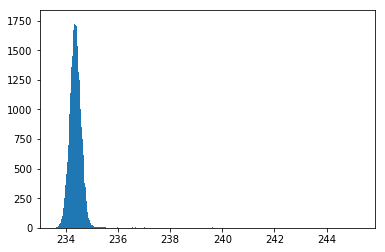

In [11]:
plt.hist(data_smooth.iloc[:,0],bins=1000)
plt.show()

# End of Data Smoothing

In [12]:
#PCA Implementation
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(data_smooth)

X_non_smoothed = StandardScaler().fit_transform(df_new)

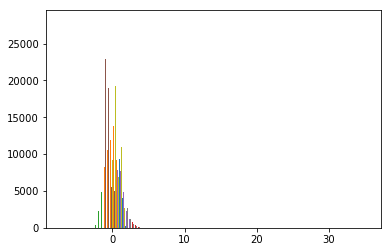

In [13]:
plt.hist(X_non_smoothed,bins=100)
plt.show()

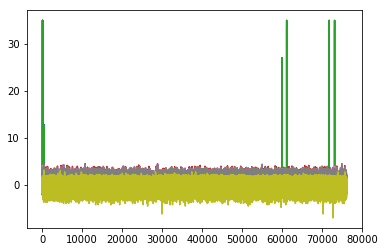

In [14]:
plt.plot(X_non_smoothed)
plt.show()

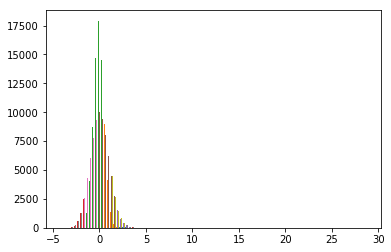

In [15]:
plt.hist(X_std,bins=100)
plt.show()

In [16]:
X_std[1000]

array([ 0.54721308,  0.61747083,  0.67114693, -0.45589307, -0.55336245,
       -0.43293026, -0.48779537, -0.48362947, -0.15695572])

In [17]:
#Calculate the z-score of all the points
from scipy import stats
zscore = stats.zscore(df_new)

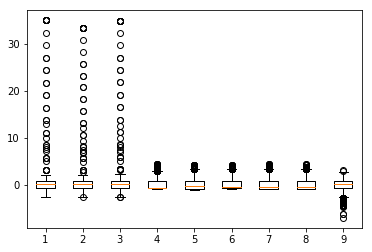

In [18]:
plt.boxplot(zscore)
plt.show()

In [19]:
from sklearn.decomposition import PCA 
sklearn_pca = PCA(n_components=9)
Y_sklearn = sklearn_pca.fit_transform(X_std)
Y_sklearn_ns = sklearn_pca.fit_transform(X_non_smoothed)

sklearn_pca.explained_variance_ratio_.cumsum()

array([ 0.66627299,  0.9089013 ,  0.98940582,  0.99535871,  0.9987822 ,
        0.99944428,  0.99990974,  0.99998256,  1.        ])

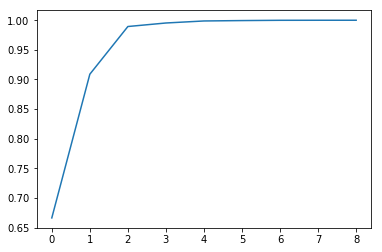

In [20]:
plt.plot(sklearn_pca.explained_variance_ratio_.cumsum())

In [21]:
#Convert the PCA to dataframe
data = pd.DataFrame(Y_sklearn_ns[:,0:3], columns=('PCA1', 'PCA2','PCA3'))
data.head()



,PCA1,PCA2,PCA3
0,-2.349339,-1.798770,0.258858
1,-1.531437,-0.978596,-0.428461
2,-0.098923,1.043191,0.025473
3,-4.017238,-0.377094,-0.926900
4,-3.664858,-0.060993,-0.365460


/home/arun/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


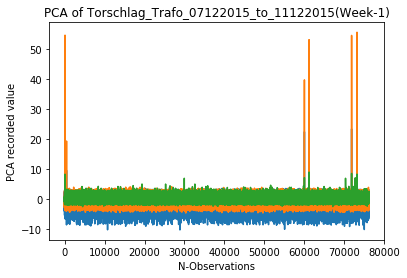

In [22]:
#Plot the PCA values
fig = plt.figure() 
plt.legend(loc='upper right')
plt.plot(data)
plt.title("PCA of Torschlag_Trafo_07122015_to_11122015(Week-1)")

#plt.legend()
plt.ylabel("PCA recorded value")
plt.xlabel("N-Observations")

# Split the data into training and testing 

def split_data(data, val_size=0, test_size=0):
    """
    splits data to training, validation and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))
    nval = int(round(len(data.iloc[:ntest]) * (1 - val_size)))
    df_train, df_val, df_test = data.iloc[:nval], data.iloc[nval:ntest], data.iloc[ntest:]
    return df_train, df_val, df_test

train, validate, test = split_data(data)

# Splitting data ends

# Method 1 : Choose the best model

In [23]:
#Fit GMM on the PCA
from sklearn.mixture import GaussianMixture
import pylab as pl

def model_fit_1(X):
    n_components = np.arange(1, 21)
    BIC = np.zeros(n_components.shape)
    AIC = np.zeros(n_components.shape)
    for i, n in enumerate(n_components):
        clf = GaussianMixture(n_components=n, covariance_type='full')
        clf.fit(X)
        AIC[i] = clf.aic(X)
        BIC[i] = clf.bic(X)
    pl.figure()
    pl.plot(n_components, AIC, label='AIC')
    pl.plot(n_components, BIC, label='BIC')
    pl.legend(loc=0)
    pl.xlabel('n_components')
    pl.ylabel('AIC / BIC')
    return clf, AIC, BIC

def gmm_ad(wgt_log_probability):
    values = []
    index = []
    threshold = 3 * wgt_log_probability.std() #Check if we can consider since its not a normal distribution
    a = np.absolute(wgt_log_probability.mean()) + threshold
    count = 0
    for i in range(0,len(wgt_log_probability)):
        #print i
        if np.absolute(wgt_log_probability[i]) > a:
            count = count + 1
            values.append(wgt_log_probability[i])
            index.append(i)
    return count, values, index
    #print values

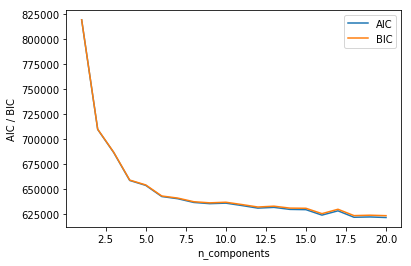

In [24]:
clf, clf_aic, clf_bic  = model_fit_1(data)

In [25]:
clf.weights_ #the weights of no_of_components, see first parameter to GaussianMixture

array([ 0.14661747,  0.08235623,  0.05315888,  0.01844478,  0.06204131,
        0.05972135,  0.0472227 ,  0.02403117,  0.00050246,  0.03597219,
        0.04084783,  0.05435092,  0.05147513,  0.0588934 ,  0.02001355,
        0.03019588,  0.00137766,  0.06158273,  0.10143274,  0.0497616 ])

In [26]:
clf.means_.shape #(n_components, n_features)

(20, 3)

The precision matrices for each component in the mixture. **A precision matrix is the inverse of a covariance matrix.** A covariance matrix is symmetric positive definite so the mixture of Gaussian can be equivalently parameterized by the precision matrices. Storing the precision matrices instead of the covariance matrices makes it more efficient to compute the log-likelihood of new samples at test time. The shape depends on covariance_type:

In [27]:
clf.covariances_.shape #(n_components, n_features, n_features) if 'full'

(20, 3, 3)

In [28]:
clf.precisions_.shape #

(20, 3, 3)

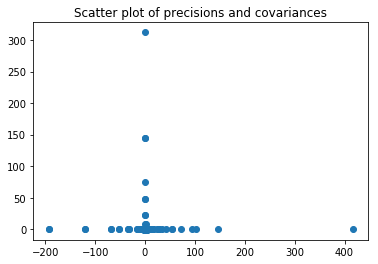

In [29]:
plt.scatter(clf.precisions_, clf.covariances_)
plt.title('Scatter plot of precisions and covariances')

In [30]:
classes = clf.predict(data)
classes

array([ 1,  1, 13, ...,  0,  1, 10])

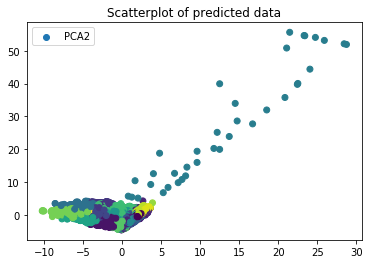

In [31]:
classes = clf.predict(data)
plt.scatter(data.iloc[:,0], data.iloc[:,1], c=classes)
plt.legend()
plt.title('Scatterplot of predicted data')
plt.show()

In [32]:
score_samp = clf.score_samples(data) #Compute the weighted log probabilities for each sample.

In [33]:
np.savetxt("Original_data.txt",score_samp)

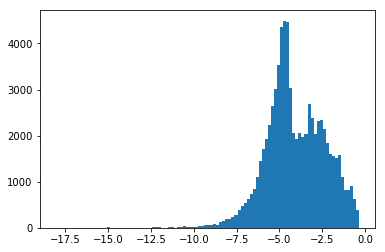

In [34]:
plt.hist(score_samp,bins =100)
plt.show()

# Calculate the confidence intervals

In [35]:
#http://stackoverflow.com/questions/4493543/calculating-confidence-intervals-for-a-non-normal-distribution
def CI_dist(X):
    N = len(X)
    mu = np.mean(abs(X))         # sample mean (normally distributed)
    print("Mean = %s"%mu)
    #sig = np.std(X)/math.sqrt(N); # sample standard deviation of the mean
    sig = np.std(X) # sample standard deviation of the mean
    print("Std = %s"%sig)
    alphao2 = .05/2;      # alpha over 2   
    CI = stats.norm.ppf(0.95, loc=mu, scale= 2.5*sig)
    return CI

In [36]:
CI = CI_dist(score_samp)
CI

Mean = 4.08169969192
Std = 1.72670296495


11.182133778354432

# Calculate the number of data points lower than -10

In [37]:
def count_no_of_points(dist,confidence_interval,filename):
    count = 0
    anomalous_values = []
    idx = []
    for i in dist:
        if i < -confidence_interval:
            count += 1
            k, = np.where(dist == i)
            idx.append(k)
            anomalous_values.append(i)
    np.savetxt(filename,anomalous_values)
    return count,idx

In [38]:
less_probable_value_count, idx_ap = count_no_of_points(score_samp,CI,"test_anomaly_range_11.txt")
less_probable_value_count, idx_ap

(124,
 [array([79]),
  array([80]),
  array([81]),
  array([82]),
  array([83]),
  array([84]),
  array([85]),
  array([86]),
  array([87]),
  array([88]),
  array([89]),
  array([99]),
  array([119]),
  array([487]),
  array([497]),
  array([498]),
  array([499]),
  array([500]),
  array([501]),
  array([502]),
  array([503]),
  array([504]),
  array([ 4058, 58393]),
  array([ 4368, 35354, 64912]),
  array([4526]),
  array([5354]),
  array([ 8439, 71099]),
  array([11005]),
  array([11180, 33391]),
  array([11839]),
  array([13370]),
  array([13897, 60411]),
  array([13992, 31986]),
  array([14499]),
  array([14746, 24122]),
  array([16502]),
  array([17159]),
  array([19380]),
  array([19485, 43308]),
  array([23752]),
  array([14746, 24122]),
  array([25279]),
  array([26270]),
  array([26380, 35807]),
  array([26822]),
  array([27186]),
  array([27273]),
  array([27762]),
  array([28124]),
  array([29950, 70281]),
  array([30610]),
  array([30689]),
  array([31660]),
  array([13992